In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from utils.occ_map_utils import load_map, show_map, plot_occ_map, plot_trajectories, free_space
from utils.occ_map_utils import display_trans_map, display_occ_map, plot_occ_map
from utils.plot_utils import plot_4d_tensor
from data_generator.human_mcm import Grid_HMM
from data_loader import get_iters
from propagation.bofum import naiveBOFUM, conditionalBOFUM

In [2]:
map_name = '100_11'
image_path = '/local/home/ful7rng/projects/transition/data_diagonal_1/maps/{}/thresholded_20.png'.format(map_name)
probs_path = '/local/home/ful7rng/projects/transition/data_diagonal_1/transition_maps/{}/astar_cost_diagonaltransverse_6_20_5/astar_cost_diagonaltransverse_6_20_5.npy'.format(map_name)
map_, _, _ = load_map(image_path)
# probs shape: width, height, last_vel_x, last_vel_y, next_vel_x, next_vel_y
probs = np.load(probs_path)

width, height = map_.shape

In [3]:
def reshape_probs(probs):
    velocities = [[0, 1], [1, 0], [0, -1], [-1, 0],
                  [1, 1], [1, -1], [-1, 1], [-1, -1]]
    v_idxs = [Grid_HMM.two_d_vel_to_idx(vel) for vel in velocities]
    probs__ = np.zeros((32, 32, 3, 3, 3, 3))
    for i in range(8):
        for j in range(8):
            probs__[:, :, v_idxs[i][0], v_idxs[i][1], v_idxs[j][0], v_idxs[j][1]] = probs[i, j, :, :]
    # # velocitiy dimensions rotate clockwise
    # plot_4d_tensor(probs[9, 25])
    # # TODO: comment out these two lines with new HMM.two_d_vel_to_idx
#     probs__ = np.rot90(probs__, 1, (2, 3))
#     probs__ = np.rot90(probs__, 1, (4, 5))
    # plot_4d_tensor(probs[9, 25])
    # print(probs[9, 25, 2, 2])
    return probs__

In [4]:
config_path = '/local/home/ful7rng/projects/transition/config.py'
train_iter, val_iter, test_iter = get_iters(config_path)
maps, labels, _ = train_iter.next()

In [5]:
patch, condi_probs = maps[0][0], labels[0]
# reshape probs
condi_probs = condi_probs.reshape(8, 8, 32, 32)
probs_ = reshape_probs(condi_probs)
print(patch.shape)
print(probs_.shape)

(32, 32)
(32, 32, 3, 3, 3, 3)


(16, 24)


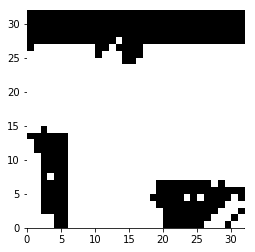

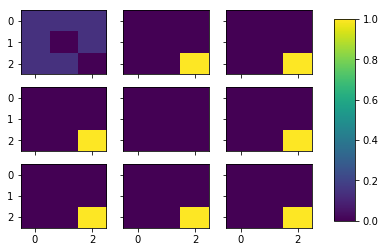

In [6]:
empty_cells = np.logical_not(patch)
free_locs = np.array(np.where(empty_cells)).T.tolist()
loc = tuple(free_locs[np.random.randint(len(free_locs))])
show_map(patch)
print(loc)
plot_4d_tensor(probs_[loc])

## initialize a BOFUM model

In [7]:
bofum = conditionalBOFUM(patch, omega=0.1, condi_probs=condi_probs, noise_var=0.6, 
                         acceleration_interpretation=True,
                         fake_network_pred=False)

In [12]:
_, _ = bofum.initialize(num_targets=1, 
                        num_steps=15, 
                        constant_speed=True,
                        diagonal=True
                       )

sampling trajectories: 1/1


t_last: 5 target loc: (11, 20)
t: 6 target loc: (12, 19)


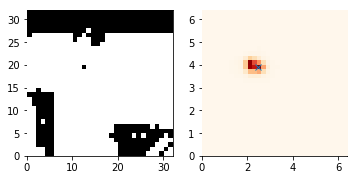

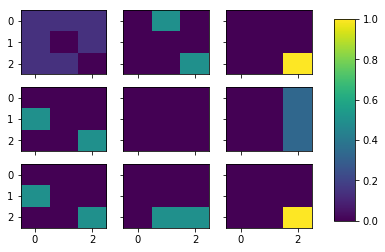

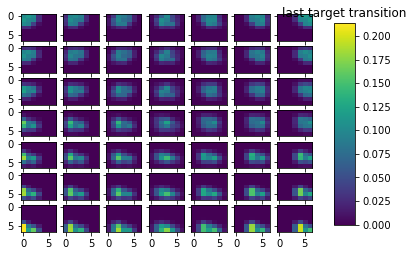

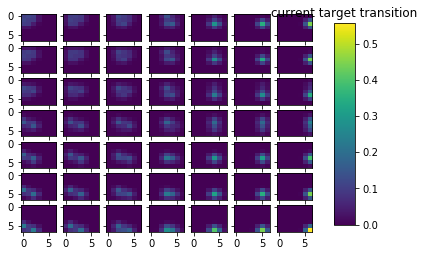

In [18]:

# propagate and show
gt = bofum.ground_truth_at()
target_loc = bofum.targets_loc_at()[0]
bofum.propagate(Z=gt)
# show current tracking result
plt.subplots(figsize=(12, 12))
plt.subplot(141)
show_map(gt)
ax = plt.subplot(142)
#show_map(bofum.P_Ot, resolution=0.2)
locs = np.unravel_index(np.argmax(bofum.P_Ot), bofum.P_Ot.shape)
#print(locs)
ax.add_image(show_map(bofum.P_Ot_pred, resolution=0.2, cmap='OrRd'))
ax.plot((locs[0]+0.5)*0.2, (locs[1]+0.5)*0.2, 'x', zorder=11)
# plot_occ_map(bofum.P_Ot_pred, bofum.P_Ot, occ_map_res=0.2, map_res=0.2)
#show_map(bofum.map, resolution=0.2)
plot_4d_tensor(probs_[target_loc])
if bofum.t > 1:
    print("t_last: {} target loc: {}".format(t_last, loc_last))
    if bofum.kernels is not None:
        plot_4d_tensor(bofum.kernels[loc_last])
        plt.title("last target transition")
        plot_4d_tensor(bofum.kernels[target_loc])
        plt.title("current target transition")
t_last, loc_last = bofum.t, target_loc
print("t: {} target loc: {}".format(bofum.t, target_loc))
plt.show()

In [27]:
x = {'x': 0}

In [28]:
str(x)

"{'x': 0}"